## Offensive Language Identification

This is the task 'a' in Task 6: OffensEval: Identifying and Categorizing Offensive Language in Social Media in SemEval 2019. We have explored how a capsule network can be used in Offensive language identification. 

In [96]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import metrics

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import *
from keras.models import *
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.initializers import *
from keras.optimizers import *
import keras.backend as K
from keras.callbacks import *
import tensorflow as tf
import os
import time
import gc
import re
from unidecode import unidecode

Get reproducable results

In [97]:
from numpy.random import seed
from tensorflow import set_random_seed

seed(726)
set_random_seed(726)

### Loading the training and testing files

In [98]:
train = pd.read_csv("Data/training/offenseval-training-v1.tsv", sep='\t')

test_tweets = pd.read_csv("Data/testing/testset-taska.tsv", sep='\t')
test_labels = pd.read_csv("Data/testing/labels-test-a.csv", header=-1, names = ["id", "subtask_a"])

test = pd.merge(test_tweets, test_labels, on=['id','id'])
print("Train shape : ", train.shape)
print("Test shape : ", test.shape)

Train shape :  (13240, 5)
Test shape :  (860, 3)


Changing case of the tweets to lower case, since the embedding model only has lower case words

In [99]:
train["tweet"] = train["tweet"].str.lower()
test["tweet"] = test["tweet"].str.lower()

cleaning the puncutation marks

In [100]:
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

def clean_text(x):

    x = str(x)
    for punct in puncts:
        x = x.replace(punct, f' {punct} ')
    return x


train["tweet"] = train["tweet"].apply(lambda x: clean_text(x))
test["tweet"] = test["tweet"].apply(lambda x: clean_text(x))

cleaning the emojis

In [101]:
import emoji
from emoji import UNICODE_EMOJI

def is_emoji(s):
    return s in UNICODE_EMOJI

def add_space(text):
    return ''.join(f' {char} ' if is_emoji(char) else char for char in text).strip()

train["tweet"] = train["tweet"].apply(lambda x: add_space(x))
test["tweet"] = test["tweet"].apply(lambda x: add_space(x))

visualize word distribution

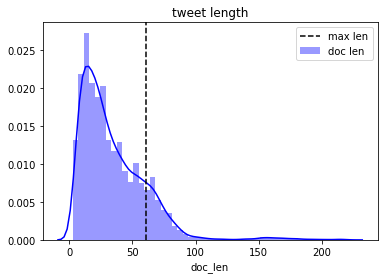

In [102]:
import seaborn as sns
import matplotlib.pyplot as plt

train['doc_len'] = train["tweet"].apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(train['doc_len'].mean() + train['doc_len'].std()).astype(int)
sns.distplot(train['doc_len'], hist=True, kde=True, color='b', label='doc len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('tweet length'); plt.legend()
plt.show()

In [103]:
## some config values 
embed_size = 300 # how big is each word vector
max_features = None # how many unique words to use (i.e num rows in embedding vector)
maxlen = max_seq_len # max number of words in a question to use #99.99%

## fill up the missing values
X = train["tweet"].fillna("_na_").values
X_test = test["tweet"].fillna("_na_").values

## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features, filters='')
tokenizer.fit_on_texts(list(X))

X = tokenizer.texts_to_sequences(X)
X_test = tokenizer.texts_to_sequences(X_test)

## Pad the sentences 
X = pad_sequences(X, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

## Get the target values
Y = train['subtask_a'].values
Y

array(['OFF', 'OFF', 'NOT', ..., 'OFF', 'OFF', 'NOT'], dtype=object)

In [118]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

le.fit(Y)
encoded_Y = le.transform(Y)
encoded_Y

array([1, 1, 0, ..., 1, 1, 0])

Load the embeddings

In [119]:
word_index = tokenizer.word_index
max_features = len(word_index)+1

EMOJI_EMBEDDING_FILE = 'E:/Models/emoji-lstm-based/emoji_embeddings_300d.txt'
# EMOJI_EMBEDDING_FILE = 'E:/Models/emoji-sum-based/emoji_embeddings_300d.txt'

# EMBEDDING_FILE = 'E:/Models/glove.840B.300d/glove.840B.300d.txt'
# EMBEDDING_FILE = 'E:/Models/crawl-300d-2M.vec'
EMBEDDING_FILE = 'E:/Models/crawl-300d-2M-subword/crawl-300d-2M-subword.vec'

def load_emoji_emb(word_index):  
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMOJI_EMBEDDING_FILE, encoding="utf8" ) if o.split(" ")[0] in word_index)  
    return embeddings_index

def load_word_emb(word_index): 
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE, encoding="utf8") if o.split(" ")[0] in word_index)
    return embeddings_index


Build the embedding matrix

In [120]:
# word embeddings only
def get_emb_matrix_word(word_index):
    embeddings_index = load_word_emb(word_index)
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    embedding_matrix = np.random.normal(emb_mean, emb_std, (max_features, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector
            
    return embedding_matrix 

# word and emoji embeddings in a single matrix with priority on word
def get_emb_matrix_wordemoji(word_index):
    embeddings_index = load_word_emb(word_index)
    emoji_embeddings_index = load_emoji_emb(word_index)
    
    word_embs = np.stack(embeddings_index.values() )
    emoji_embs = np.stack(emoji_embeddings_index.values() )
    all_embs = np.concatenate((word_embs, emoji_embs))   
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]
    
    embedding_matrix = np.random.normal(emb_mean, emb_std, (max_features, embed_size))
    
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
        else:
            embedding_vector = emoji_embeddings_index.get(word) 
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
    
    return embedding_matrix

# word and emoji embedings in a single matrix with priority on emoji
def get_emb_matrix_emojiword(word_index):
    embeddings_index = load_word_emb(word_index)
    emoji_embeddings_index = load_emoji_emb(word_index)
    
    word_embs = np.stack(embeddings_index.values() )
    emoji_embs = np.stack(emoji_embeddings_index.values() )
    all_embs = np.concatenate((word_embs, emoji_embs))   
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]
    
    embedding_matrix = np.random.normal(emb_mean, emb_std, (max_features, embed_size))
    
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = emoji_embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
        else:
            embedding_vector = embeddings_index.get(word) 
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
    
    return embedding_matrix

# word and emoji embeddings in seperate matrices with priority on word
def get_emb_matrix_word_emoji(word_index):
    embeddings_index = load_word_emb(word_index)
    emoji_embeddings_index = load_emoji_emb(word_index)
    
    word_embs = np.stack(embeddings_index.values() )
    emoji_embs = np.stack(emoji_embeddings_index.values() )
    
    word_emb_mean, word_emb_std = word_embs.mean(), word_embs.std()
    word_emb_size = word_embs.shape[1]
        
    emoji_emb_mean, emoji_emb_std = emoji_embs.mean(), emoji_embs.std()
    emoji_emb_size = emoji_embs.shape[1]

    embedding_matrix = np.random.normal(word_emb_mean, word_emb_std, (max_features, word_emb_size))
    emoji_embedding_matrix = np.random.normal(emoji_emb_mean, emoji_emb_std, (max_features, emoji_emb_size))
    
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
        else:
            embedding_vector = emoji_embeddings_index.get(word) 
            if embedding_vector is not None: 
                emoji_embedding_matrix[i] = embedding_vector
                    
    return embedding_matrix, emoji_embedding_matrix

Get customized embedding matrix

In [121]:
# embedding_matrix = get_emb_matrix_word(word_index)
embedding_matrix = get_emb_matrix_wordemoji(word_index)
# embedding_matrix = get_emb_matrix_emojiword(word_index)

# embedding_matrix, emoji_embedding_matrix = get_emb_matrix_word_emoji(word_index)

C:\Users\Hansi\Anaconda3\envs\aggr-det\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
C:\Users\Hansi\Anaconda3\envs\aggr-det\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Definning the Capsule Layer in Keras

In [122]:
def squash(x, axis=-1):
    s_squared_norm = K.sum(K.square(x), axis, keepdims=True)
    scale = K.sqrt(s_squared_norm + K.epsilon())
    return x / scale

In [123]:
class Capsule(Layer):
    def __init__(self, num_capsule, dim_capsule, routings=3, kernel_size=(9, 1), share_weights=True,
                 activation='default', **kwargs):
        super(Capsule, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.kernel_size = kernel_size
        self.share_weights = share_weights
        if activation == 'default':
            self.activation = squash
        else:
            self.activation = Activation(activation)

    def build(self, input_shape):
        super(Capsule, self).build(input_shape)
        input_dim_capsule = input_shape[-1]
        if self.share_weights:
            self.W = self.add_weight(name='capsule_kernel',
                                     shape=(1, input_dim_capsule,
                                            self.num_capsule * self.dim_capsule),
                                     # shape=self.kernel_size,
                                     initializer='glorot_uniform',
                                     trainable=True)
        else:
            input_num_capsule = input_shape[-2]
            self.W = self.add_weight(name='capsule_kernel',
                                     shape=(input_num_capsule,
                                            input_dim_capsule,
                                            self.num_capsule * self.dim_capsule),
                                     initializer='glorot_uniform',
                                     trainable=True)
            
    def call(self, u_vecs):
        if self.share_weights:
            u_hat_vecs = K.conv1d(u_vecs, self.W)
        else:
            u_hat_vecs = K.local_conv1d(u_vecs, self.W, [1], [1])

        batch_size = K.shape(u_vecs)[0]
        input_num_capsule = K.shape(u_vecs)[1]
        u_hat_vecs = K.reshape(u_hat_vecs, (batch_size, input_num_capsule, self.num_capsule, self.dim_capsule))
        u_hat_vecs = K.permute_dimensions(u_hat_vecs, (0, 2, 1, 3))
        # final u_hat_vecs.shape = [None, num_capsule, input_num_capsule, dim_capsule]

        b = K.zeros_like(u_hat_vecs[:, :, :, 0])  # shape = [None, num_capsule, input_num_capsule]
        for i in range(self.routings):
            b = K.permute_dimensions(b, (0, 2, 1))  # shape = [None, input_num_capsule, num_capsule]
            c = K.softmax(b)
            c = K.permute_dimensions(c, (0, 2, 1))
            b = K.permute_dimensions(b, (0, 2, 1))
            outputs = self.activation(K.batch_dot(c, u_hat_vecs, [2, 2]))
            if i < self.routings - 1:
                b = K.batch_dot(outputs, u_hat_vecs, [2, 3])

        return outputs

    def compute_output_shape(self, input_shape):
        return (None, self.num_capsule, self.dim_capsule)

Capsule Layer with a Bi directional GRU. Architecture found in text classification project.

In [124]:
def capsule():
    K.clear_session()       
    inp = Input(shape=(maxlen,))
#     word = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=False)(inp)
#     emoji = Embedding(max_features, embed_size, weights=[emoji_embedding_matrix], trainable=False)(inp)
#     x = concatenate([(word), (emoji)])

    x = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=False)(inp)
    
    x = SpatialDropout1D(rate=0.2)(x)
#     x = Bidirectional(LSTM(64, return_sequences=True))(x)
    x = Bidirectional(GRU(100, return_sequences=True, 
                                kernel_initializer=glorot_normal(seed=12300), recurrent_initializer=orthogonal(gain=1.0, seed=10000)))(x)

    x = Capsule(num_capsule=10, dim_capsule=10, routings=4, share_weights=True)(x)
    x = Flatten()(x)

    x = Dense(100, activation="relu", kernel_initializer=glorot_normal(seed=12300))(x)
    x = Dropout(0.12)(x)
    x = BatchNormalization()(x)

    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer=Adam(),)
    return model

In [125]:
def f1_smart(y_true, y_pred):
    args = np.argsort(y_pred)
    tp = y_true.sum()
    fs = (tp - np.cumsum(y_true[args[:-1]])) / np.arange(y_true.shape[0] + tp - 1, tp, -1)
    res_idx = np.argmax(fs)
    return 2 * fs[res_idx], (y_pred[args[res_idx]] + y_pred[args[res_idx + 1]]) / 2

Training with early stopping and reducing learning rate on plateu. In each fold values for the test set is also predicted, And after the process, predicted values for the test file would be mean from each fold

In [126]:
kfold = StratifiedKFold(n_splits=5, random_state=10, shuffle=True)
bestscore = []
y_test = np.zeros((X_test.shape[0], ))
for i, (train_index, valid_index) in enumerate(kfold.split(X, encoded_Y)):
    X_train, X_val, Y_train, Y_val = X[train_index], X[valid_index], encoded_Y[train_index], encoded_Y[valid_index]
    filepath="Models/capsule_net_weights_best.h5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=2, save_best_only=True, mode='min')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=1, min_lr=0.0001, verbose=2)
    earlystopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=2, verbose=2, mode='auto')
    callbacks = [checkpoint, reduce_lr]
    model = capsule()
    if i == 0:print(model.summary()) 
    model.fit(X_train, Y_train, batch_size=64, epochs=20, validation_data=(X_val, Y_val), verbose=2, callbacks=callbacks, 
             )
    model.load_weights(filepath)
    y_pred = model.predict([X_val], batch_size=64, verbose=2)
    y_test += np.squeeze(model.predict([X_test], batch_size=64, verbose=2))/5
    f1, threshold = f1_smart(np.squeeze(Y_val), np.squeeze(y_pred))
    print('Optimal F1: {:.4f} at threshold: {:.4f}'.format(f1, threshold))
    bestscore.append(threshold)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 61)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 61, 300)           5873100   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 61, 300)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 61, 200)           240600    
_________________________________________________________________
capsule_1 (Capsule)          (None, 10, 10)            20000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
__________


Epoch 00003: val_loss improved from 0.58225 to 0.51305, saving model to Models/capsule_net_weights_best.h5
Epoch 4/20
 - 43s - loss: 0.4862 - val_loss: 0.4645

Epoch 00004: val_loss improved from 0.51305 to 0.46449, saving model to Models/capsule_net_weights_best.h5
Epoch 5/20
 - 43s - loss: 0.4650 - val_loss: 0.4655

Epoch 00005: val_loss did not improve from 0.46449

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.
Epoch 6/20
 - 43s - loss: 0.4572 - val_loss: 0.4877

Epoch 00006: val_loss did not improve from 0.46449

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0003600000170990825.
Epoch 7/20
 - 43s - loss: 0.4497 - val_loss: 0.4961

Epoch 00007: val_loss did not improve from 0.46449

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.00021600000327453016.
Epoch 8/20
 - 43s - loss: 0.4416 - val_loss: 0.4501

Epoch 00008: val_loss improved from 0.46449 to 0.45012, saving model to Models/capsule_net_weights_best.h5
Epoch 9/20
 - 43

Converting the predictions for integer.

In [127]:
y_test = y_test.reshape((-1, 1))
pred_test_y = (y_test>np.mean(bestscore)).astype(int)
test['predictions'] = le.inverse_transform(pred_test_y)

# save predictions
file_path = 'E:\Work Spaces\Python\Aggression-Identification\Evaluation\predictions.tsv'
test.to_csv(file_path, sep='\t', encoding='utf-8')

C:\Users\Hansi\Anaconda3\envs\aggr-det\lib\site-packages\sklearn\preprocessing\label.py:273: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Confusion Matrix

In [128]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(test["subtask_a"], test['predictions']).ravel()
(tn, fp, fn, tp)

(544, 76, 64, 176)

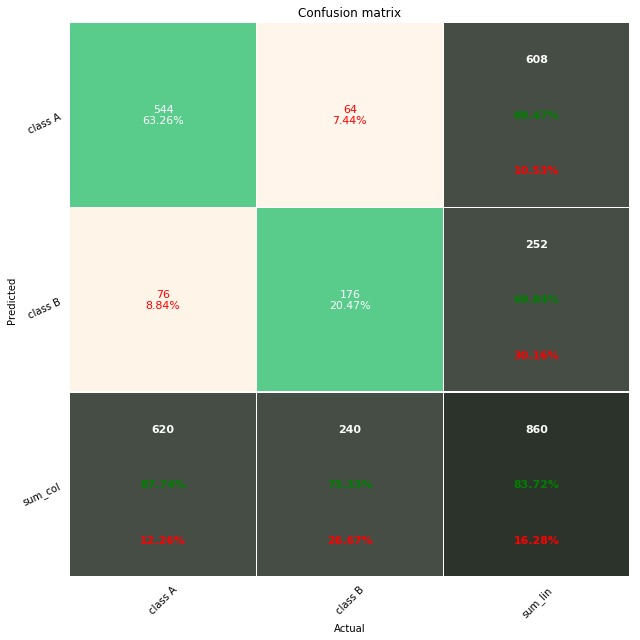

In [129]:
from visualization.confusion_matrix_pretty_print import plot_confusion_matrix_from_data

columns = []
annot = True
cmap = 'Oranges'
fmt = '.2f'
lw = 0.5
cbar = False
show_null_values = 2
pred_val_axis = 'y'
# size::
fz = 12;
figsize = [9, 9];
if len(y_test) > 10:
    fz = 9;
    figsize = [14, 14];
plot_confusion_matrix_from_data(test["subtask_a"], test['predictions'], columns,
                                    annot, cmap, fmt, fz, lw, cbar, figsize, show_null_values, pred_val_axis)

### Accuracy

In [130]:
from sklearn.metrics import accuracy_score
accuracy_score(test["subtask_a"], test['predictions'])

0.8372093023255814

### Macro F1 

In [131]:
from sklearn.metrics import f1_score
f1_score(test["subtask_a"], test['predictions'], labels=None, pos_label=1, average='macro', sample_weight=None)

0.800720319906782